# Importing libraries

In [1]:
! pip install latex
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 
! apt install cm-super
! pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for latex: filename=latex-0.7.0-py3-none-any.whl size=7606 sha256=55cd24bbde0319c83eb80d1d7a05197861d2d32cf1f50be76a2a301399e458e2
  Stored in directory: /root/.cache/pip/wheels/16/c1/33/30e79ef1232ec43bb51b17ad60c5bfa6849fa0c9bc939ca089
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7246 sha256=3e609128e3dec59ed38738c1877874f8e5467f6ca4b1e92fd505b9a79979e728
  Stored in directory: /root/.cache/pip/wheels/5c/78/30/ac68ac8de8481b3b4334617a48ef1758323f30709b2f923362
  Created wheel for shutilwhich: filename=shutilwhich-1.1.0-py3-none-any.whl size=2782 sha256=247628430fe2d6f529455e39bda698af386e398d6f418218bf28841f71f8a8e1
  Stored in directory: /root/.cache/pip/wheels/27/f1/8b/8e9215b5809387fcf9

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
#matplotlib.use('PS')
rc('text', usetex=True)
import seaborn as sns; sns.set()
sns.set_theme(style="ticks")

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Palatino']
#rc('font', **{'family':'serif','serif':['Palatino']})

In [3]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
%cd gdrive/MyDrive/FYP/screening_power

/content/gdrive/MyDrive/FYP/screening_power


In [5]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2023-02-03 03:00:40--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2023-02-03 03:00:40--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

In [6]:
import pingouin as pg
import ensembling
import filtering
import metrics
import parsing
import plotting_utils
import postprocessing

# Screening power test

In [7]:
AVG_FUN = np.nanmedian  # Reduce function to compute averages across targets. Using nanmedian because there is one target missing from RF/NN-score
EF_ALPHA = 0.01 # alpha for EF metric (i.e., EF1)
BEDROC_ALPHA = 80.5 # alpha for BedROC metric (i.e, BedROC80.5)

In [8]:
PERFORMANCE_METRICS = ['AUROC', 'EF1', 'BEDROC80.5']
DATASET = 'DUD-E'

MAIN_PATH = '/content/gdrive/MyDrive/FYP/screening_power'
PROTEIN_LIGAND_PAIR_REDUCE = 'max'  # Reduce function for protein-ligand pairs multiple entries (e.g. Vina, docking, RF/NN-score, DeepDTA)
PAIR_ID_COLS = ['target_id', 'ligand_id']  # Specifies a unique protein-ligand pair

PATH_RESULTS = {
    '5HL_Re-ComBind': os.path.join(MAIN_PATH, '5HL_dude_recombind.csv'),
    '10HL_Re-ComBind': os.path.join(MAIN_PATH, '10HL_dude_recombind.csv'),
    '20HL_Re-ComBind': os.path.join(MAIN_PATH, '20HL_dude_recombind.csv'),
    '30HL_Re-ComBind': os.path.join(MAIN_PATH, '30HL_dude_recombind.csv'),
    '40HL_Re-ComBind': os.path.join(MAIN_PATH, '40HL_dude_recombind.csv'),
    '50HL_Re-ComBind': os.path.join(MAIN_PATH, '50HL_dude_recombind.csv'),
    'AutoDock Vina': os.path.join(MAIN_PATH, 'dude.csv'),
    'RF-score': os.path.join(MAIN_PATH, 'rfnn_dude_scores'),
    'NN-score': os.path.join(MAIN_PATH, 'rfnn_dude_scores'),\
    'Gold': os.path.join(MAIN_PATH, 'docking_performance_scores', 'gold.csv'),
    'Glide': os.path.join(MAIN_PATH, 'docking_performance_scores', 'glide.csv'),
    'Surflex': os.path.join(MAIN_PATH, 'docking_performance_scores', 'surflex.csv'),
    'Flexx': os.path.join(MAIN_PATH, 'docking_performance_scores', 'flexx.csv'),
    'GNINA': os.path.join(MAIN_PATH, 'newdefault_CNNaffinity-max.summary'),
}

In [9]:
results = dict()  # key-value pairs that will store the outputs DataFrame instances

print(f"Parsing Vina results...")
model = 'AutoDock Vina'
results[model] = parsing.parse_results_vina(PATH_RESULTS[model], reduce=PROTEIN_LIGAND_PAIR_REDUCE)  

print(f"Parsing 5HL Re-Combind results...")
model = '5HL_Re-ComBind'
results[model] = parsing.parse_results_vina(PATH_RESULTS[model], reduce=PROTEIN_LIGAND_PAIR_REDUCE) 

print(f"Parsing 10HL Re-Combind results...")
model = '10HL_Re-ComBind'
results[model] = parsing.parse_results_vina(PATH_RESULTS[model], reduce=PROTEIN_LIGAND_PAIR_REDUCE)

print(f"Parsing 20HL Re-Combind results...")
model = '20HL_Re-ComBind'
results[model] = parsing.parse_results_vina(PATH_RESULTS[model], reduce=PROTEIN_LIGAND_PAIR_REDUCE)

print(f"Parsing 30HL Re-Combind results...")
model = '30HL_Re-ComBind'
results[model] = parsing.parse_results_vina(PATH_RESULTS[model], reduce=PROTEIN_LIGAND_PAIR_REDUCE)

print(f"Parsing 40HL Re-Combind results...")
model = '40HL_Re-ComBind'
results[model] = parsing.parse_results_vina(PATH_RESULTS[model], reduce=PROTEIN_LIGAND_PAIR_REDUCE)

print(f"Parsing 50HL Re-Combind results...")
model = '50HL_Re-ComBind'
results[model] = parsing.parse_results_vina(PATH_RESULTS[model], reduce=PROTEIN_LIGAND_PAIR_REDUCE)

print(f"Parsing GNINA results...")
model = 'GNINA'
results[model] = parsing.parse_results_gnina(PATH_RESULTS[model])

print(f"Parsing NN-score results...")
model = 'NN-score'
results[model] = parsing.parse_results_nn_score(PATH_RESULTS[model], reduce=PROTEIN_LIGAND_PAIR_REDUCE, prog_bar=True)

print(f"Parsing RF-score results...")
model = 'RF-score'
results[model] = parsing.parse_results_rf_score(PATH_RESULTS[model], reduce=PROTEIN_LIGAND_PAIR_REDUCE, prog_bar=True)

Parsing Vina results...
Parsing 5HL Re-Combind results...
Parsing 10HL Re-Combind results...
Parsing 20HL Re-Combind results...
Parsing 30HL Re-Combind results...
Parsing 40HL Re-Combind results...
Parsing 50HL Re-Combind results...
Parsing GNINA results...
Parsing NN-score results...


100%|██████████| 101/101 [11:49<00:00,  7.02s/it]


Parsing RF-score results...


100%|██████████| 101/101 [11:22<00:00,  6.76s/it]


In [10]:
filtering_list = []
for _, result in results.items():
    filtering_list.append(list(result.target_id.unique()))
target_union = filtering.target_union(filtering_list)

missing_targets = dict()  # One entry per model
for model, result in results.items():
    taget_diff = (set(target_union)) - set(result.target_id.unique())
    missing_targets[model] = taget_diff
    print(f'Missing targets, {model}: {missing_targets[model]}')
    
results_tf = pd.DataFrame(columns=['Dataset', 'Model'] + PERFORMANCE_METRICS)  # micro-average DataFrame (tidy-format)
results_pt_tf = pd.DataFrame(columns=['Dataset', 'Model', 'Target'] + PERFORMANCE_METRICS)  # Per-targety DataFrame (tidy-format)

Missing targets, AutoDock Vina: set()
Missing targets, 5HL_Re-ComBind: {'fgfr1'}
Missing targets, 10HL_Re-ComBind: {'fgfr1'}
Missing targets, 20HL_Re-ComBind: {'fgfr1'}
Missing targets, 30HL_Re-ComBind: {'fgfr1'}
Missing targets, 40HL_Re-ComBind: {'fgfr1'}
Missing targets, 50HL_Re-ComBind: {'fgfr1'}
Missing targets, GNINA: set()
Missing targets, NN-score: {'csf1r'}
Missing targets, RF-score: {'csf1r'}


In [11]:
for model, result in results.items():
    # Compute per-target and micro-average scores
    auroc_pt, auroc_micro = metrics.compute_auroc_scores(result, avg_fun=AVG_FUN)
    ef1_pt, ef1_micro = metrics.compute_ef_scores(result, alpha=EF_ALPHA, avg_fun=AVG_FUN)
    #ef5_pt, ef5_micro = metrics.compute_ef_scores(result, alpha=0.05, avg_fun=AVG_FUN)
    bedroc805_pt, bedroc805_micro = metrics.compute_bedroc_scores(result, alpha=BEDROC_ALPHA, avg_fun=AVG_FUN)

    # Update micro DataFrame
    results_tf = pd.concat((results_tf, pd.DataFrame.from_records({
        'Dataset': DATASET,
        'Model': model,
        'AUROC': auroc_micro,
        'EF1': ef1_micro,
        'BEDROC80.5': bedroc805_micro}, 
        index=[len(results_tf)])))

    new_df_pt = pd.DataFrame.from_records(
        [auroc_pt, ef1_pt, bedroc805_pt],
        index=['AUROC', 'EF1', 'BEDROC80.5']).T.reset_index(level=0, inplace=False).rename({'index': 'Target'}, axis=1, inplace=False)
    # If there are missing targets for this model, add entries with nan values (to make statistical comparisons feasible)
    if len(missing_targets[model]):
        for missing_target in missing_targets[model]:
            new_df_pt = pd.concat(
                (new_df_pt, pd.DataFrame({
                    'Target': missing_target,
                    'AUROC': np.nan,
                    'EF1': np.nan,
                    'BEDROC80.5': np.nan},
                    index=[len(new_df_pt)])), axis='index')
    new_df_pt.insert(0, 'Dataset', DATASET)
    new_df_pt.insert(1, 'Model', model)
    results_pt_tf = pd.concat((results_pt_tf, new_df_pt))

In [12]:
for model in ['Gold', 'Glide', 'Surflex', 'Flexx']:
    # Update per-target DataFrame
    new_df_pt = pd.read_csv(PATH_RESULTS[model])
    new_df_pt.insert(0, 'Dataset', DATASET)
    new_df_pt.insert(1, 'Model', model)
    results_pt_tf = pd.concat((results_pt_tf, new_df_pt))
    
    # Update micro-average DataFrame
    results_tf = pd.concat((results_tf, pd.DataFrame.from_records({
        'Dataset': DATASET,
        'Model': model,
        'AUROC': AVG_FUN(new_df_pt['AUROC']),
        'EF1': AVG_FUN(new_df_pt['EF1']),
        'BEDROC80.5': AVG_FUN(new_df_pt['BEDROC80.5'])},
        index=[len(results_tf)])))

In [13]:
print_order = ['5HL_Re-ComBind', '10HL_Re-ComBind', '20HL_Re-ComBind', '30HL_Re-ComBind', '40HL_Re-ComBind', '50HL_Re-ComBind', 
               'AutoDock Vina', 'Gold', 'Glide', 'Surflex', 'Flexx', 'GNINA', 'RF-score', 'NN-score']
cols = ['AUROC', 'EF1', 'BEDROC80.5']
print_df = results_tf.set_index('Model').loc[print_order][cols].round(decimals=2)
print(print_df)

                 AUROC    EF1  BEDROC80.5
Model                                    
5HL_Re-ComBind    0.68   2.00        0.18
10HL_Re-ComBind   0.68   2.00        0.19
20HL_Re-ComBind   0.67   2.00        0.21
30HL_Re-ComBind   0.68   2.00        0.22
40HL_Re-ComBind   0.68   2.00        0.22
50HL_Re-ComBind   0.68   2.00        0.23
AutoDock Vina     0.75   6.84        0.14
Gold              0.86  21.08        0.39
Glide             0.82  21.96        0.35
Surflex           0.75   9.36        0.19
Flexx             0.76  10.10        0.20
GNINA             0.79  15.48        0.29
RF-score          0.62   2.00        0.05
NN-score          0.58   1.38        0.03


# Plot screening power

In [14]:
sns.set_context("paper", font_scale=.8, rc={"lines.linewidth": 1.5})
hue_order = ['5HL_Re-ComBind', '10HL_Re-ComBind', '20HL_Re-ComBind', '30HL_Re-ComBind', '40HL_Re-ComBind', '50HL_Re-ComBind', 
             'AutoDock Vina', 'Gold', 'Glide', 'Surflex', 'Flexx', 'GNINA', 'RF-score', 'NN-score']
color_palette = sns.color_palette("Blues", 6) + sns.color_palette("Oranges", 3) + sns.color_palette("Greens", 3) + sns.color_palette("Greys", 2)
metrics_ = ['AUROC', 'EF1', 'BEDROC80.5']

In [15]:
showfliers = True
fliersize = 1
linewidth = 1.2
figsize = (8, 10)
leg_pos = (0, 1.3)

label_alias = {
    '5HL_Re-ComBind': '5HL\_Re-ComBind',
    '10HL_Re-ComBind': '10HL\_Re-ComBind',
    '20HL_Re-ComBind': '20HL\_Re-ComBind',
    '30HL_Re-ComBind': '30HL\_Re-ComBind',
    '40HL_Re-ComBind': '40HL\_Re-ComBind',
    '50HL_Re-ComBind': '50HL\_Re-ComBind',
    'AutoDock Vina': 'AutoDock Vina',
    'GNINA': 'GNINA',
    'RF-score': 'RF-score',
    'NN-score': 'NN-score',
    'Gold': 'Gold',
    'Glide': 'Glide',
    'Surflex': 'Surflex',
    'Flexx': 'FlexX'
}

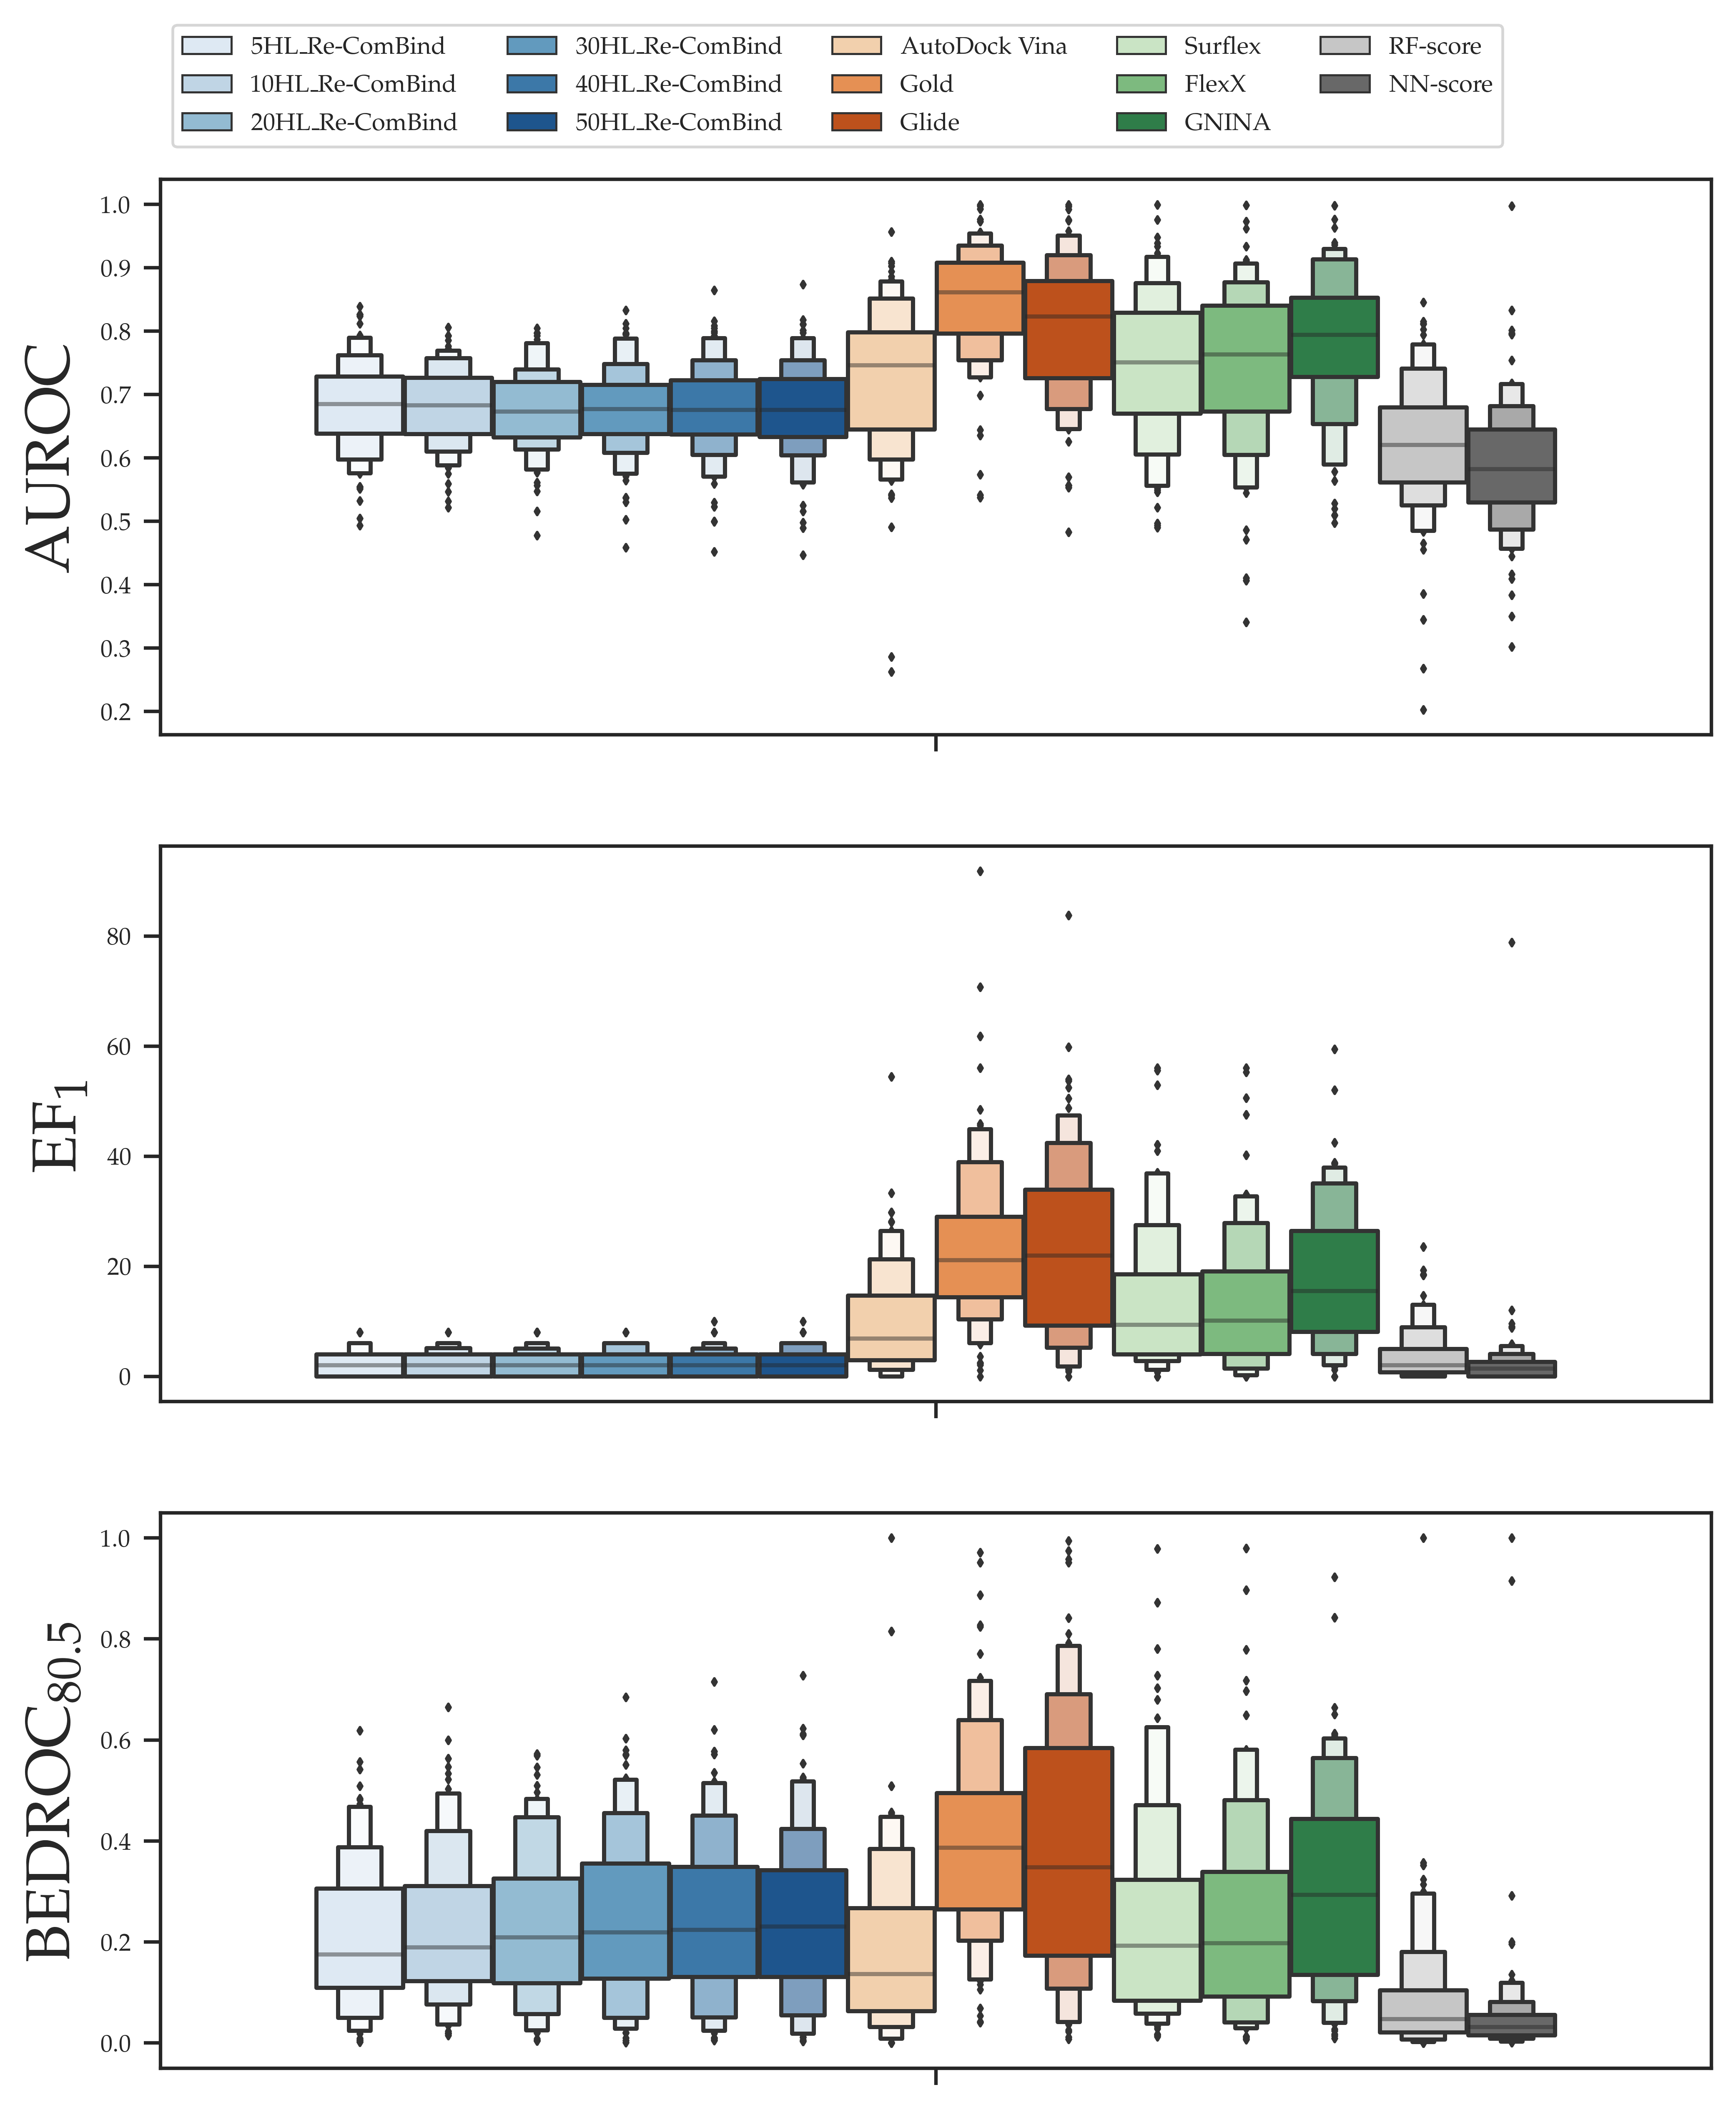

In [16]:
fig, ax = plt.subplots(figsize=figsize, nrows=3, ncols=1, dpi=600)
for i, metric in enumerate(metrics_):
    sns.boxenplot(
        data=results_pt_tf,
        x='Dataset',
        order=['DUD-E'],
        hue='Model',
        y=metric,
        hue_order=hue_order,
        palette=color_palette,
        showfliers=showfliers,
        linewidth=linewidth,
        ax=ax[i])

# Legend options
ax[0].set_ylabel(r'AUROC', fontsize=18)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles, labels=[label_alias[l] for l in labels], bbox_to_anchor=leg_pos, loc='upper left', ncol=5)

for ax_ in ax:
    ax_.set_xticklabels([])
    ax_.set_xlabel('')
    # Temporary workaround for setting fliersize for boxenplot
    # see: https://github.com/mwaskom/seaborn/issues/2701
    plt.setp(ax_.collections[::2], sizes=[2 ** fliersize])

for ax_ in ax[1:]:
    ax_.legend().remove()

ax[1].set_ylabel(r'EF$_{1}$', fontsize=18)
ax[2].set_ylabel(r'BEDROC$_{80.5}$', fontsize=18)
plt.show()

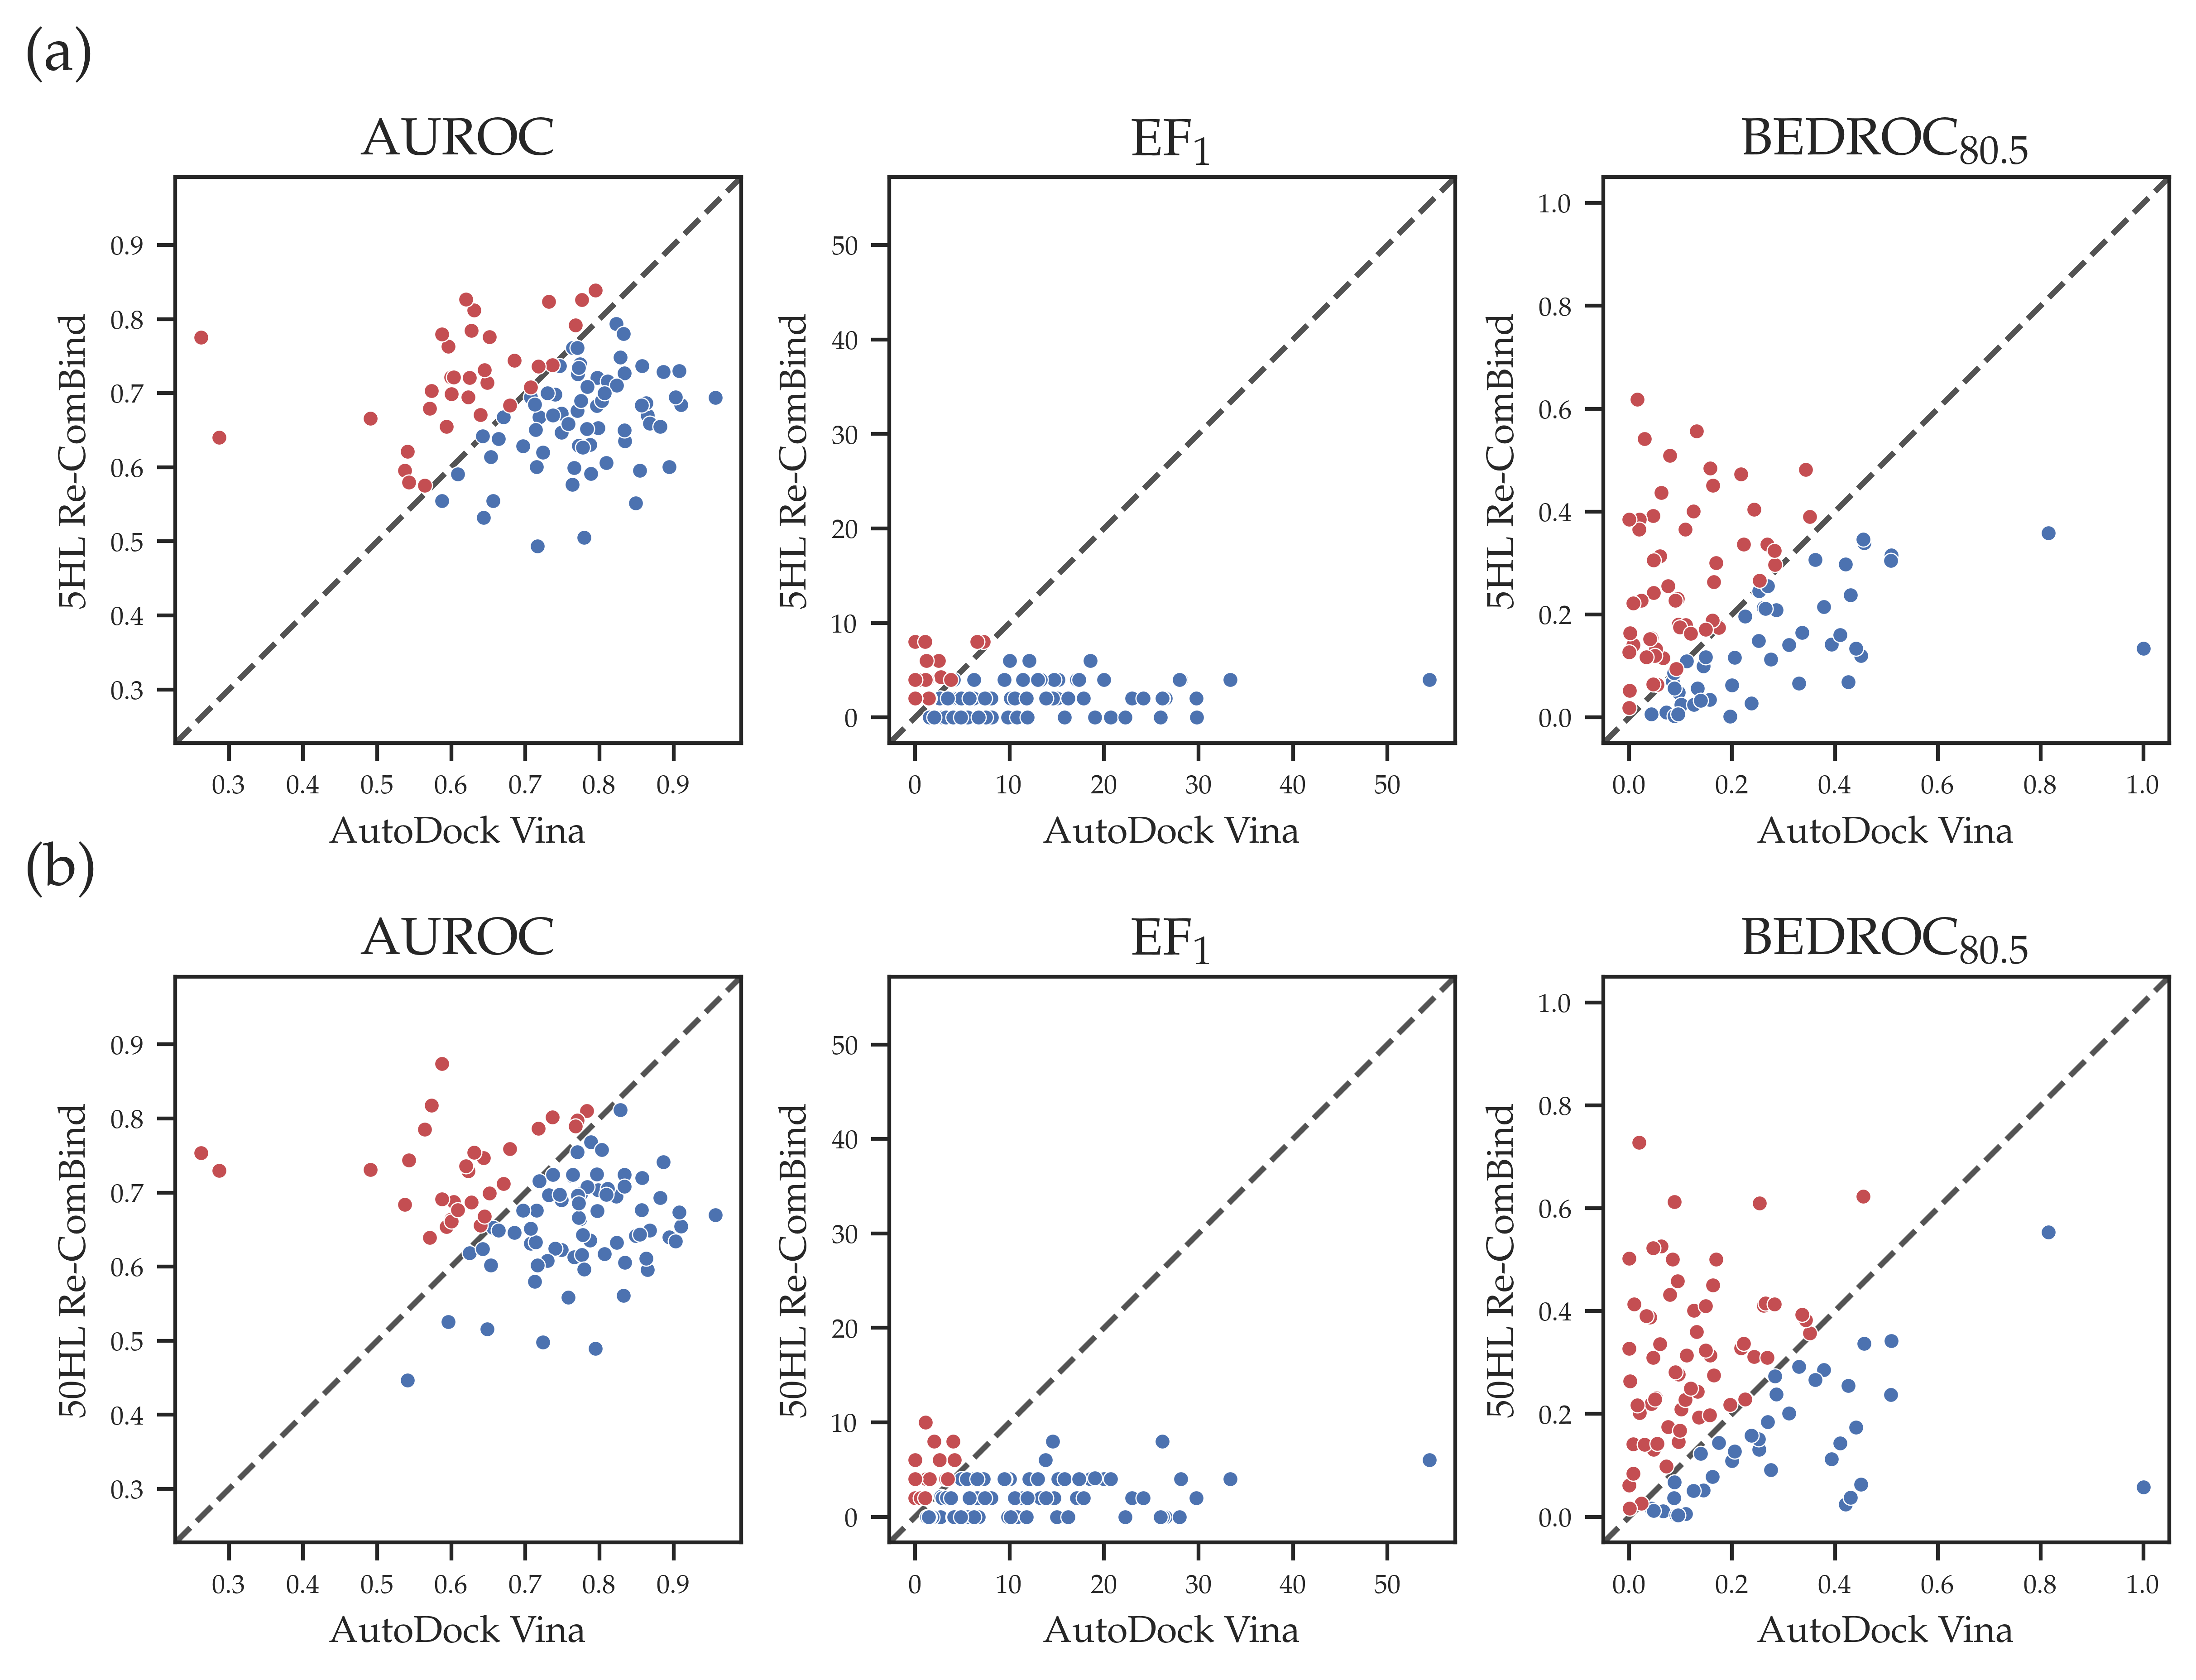

In [17]:
sns.set_context("paper", font_scale=.8, rc={"lines.linewidth": 1.5})
figsize = (8,6)
size = 16
aspect_ratio = 0.7
aspect_ratio = 1.0

# Colors are defined in the cell above, we just index them here
denvis_g_col = color_palette[0]
denvis_r_col = color_palette[1]
gnina_col = color_palette[9]
gold_col = color_palette[4]
col_1, col_2 = sns.color_palette('Paired')[8:10]
col_1, col_2 = sns.color_palette(n_colors=4)[0], sns.color_palette(n_colors=4)[3]

fig, ax = plt.subplots(figsize=figsize, nrows=2, ncols=3, dpi=600)
comparisons = [
    ('5HL_Re-ComBind', 'AutoDock Vina'),
    ('50HL_Re-ComBind', 'AutoDock Vina')]
name = [
    ('5HL Re-ComBind', 'AutoDock Vina'),
    ('50HL Re-ComBind', 'AutoDock Vina')]

for row_id, comparison in enumerate(comparisons):
    for col_id, metric in enumerate(PERFORMANCE_METRICS):
        our_scores = results_pt_tf[(results_pt_tf['Model']==comparison[0])][metric].values
        other_scores = results_pt_tf[(results_pt_tf['Model']==comparison[1])][metric].values
        
        sns.scatterplot(
            x=other_scores[other_scores > our_scores],
            y=our_scores[other_scores > our_scores],
            color=col_1,
            s=size,
            ax=ax[row_id, col_id])
        sns.scatterplot(
            x=other_scores[other_scores < our_scores],
            y=our_scores[other_scores < our_scores],
            color=col_2,
            s=size,
            ax=ax[row_id, col_id])
        plotting_utils.plot_diagonal_line(ax[row_id, col_id])
        ax[row_id, col_id].set_ylabel(name[0], fontsize=10)
        ax[row_id, col_id].set_xlabel(name[1], fontsize=10)
        ax[row_id, col_id].set_title(metric, fontsize=14)

ax[0, 0].set_ylabel('5HL Re-ComBind', fontsize=10)
ax[0, 1].set_ylabel('5HL Re-ComBind', fontsize=10)
ax[0, 2].set_ylabel('5HL Re-ComBind', fontsize=10)
ax[1, 0].set_ylabel('50HL Re-ComBind', fontsize=10)
ax[1, 1].set_ylabel('50HL Re-ComBind', fontsize=10)
ax[1, 2].set_ylabel('50HL Re-ComBind', fontsize=10)
ax[0, 0].set_xlabel('AutoDock Vina', fontsize=10)
ax[0, 1].set_xlabel('AutoDock Vina', fontsize=10)
ax[0, 2].set_xlabel('AutoDock Vina', fontsize=10)
ax[1, 0].set_xlabel('AutoDock Vina', fontsize=10)
ax[1, 1].set_xlabel('AutoDock Vina', fontsize=10)
ax[1, 2].set_xlabel('AutoDock Vina', fontsize=10)
ax[0, 1].set_title(r'EF$_{1}$', fontsize=14)
ax[1, 1].set_title(r'EF$_{1}$', fontsize=14)
ax[0, 2].set_title(r'BEDROC$_{80.5}$', fontsize=14)
ax[1, 2].set_title(r'BEDROC$_{80.5}$', fontsize=14)

# Tidy-up
for ax_ in ax.reshape(-1,):
    ax_.set_xticks(ax_.get_yticks()[1:-1])
    ax_.set_yticks(ax_.get_yticks()[1:-1])
          
fig.text(0, 1.0, '(a)', fontsize=16)
fig.text(0, 0.5, '(b)', fontsize=16)
fig.tight_layout()
plt.show()